# Imports

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os
import json

In [2]:
# Set the path to the dataset directory
BASEPATH = "/kaggle/input/stanford-dogs-dataset/images/Images"

In [3]:
# Set the directory to the dataset images
filelist  = []
for dirname, _, filenames in os.walk(BASEPATH):
    for filename in filenames:
        filelist.append(os.path.join(dirname, filename))
print('Total number of images:', len(filelist))

Total number of images: 20580


In [4]:
# Split the file paths and the labels
Filepaths = []
labels = []
for image_file in filelist:
    label = image_file.split(os.path.sep)[-2].split('-')[1]
    Filepaths.append(image_file)
    labels.append(label)
num_classes = len(set(labels)) 
print('Total number of labels:', num_classes)

Total number of labels: 120


In [5]:
# Create a Pandas dataframe to store the file paths and labels, and shuffle the dataframe
df = pd.DataFrame(list(zip(Filepaths, labels)), columns = ['Filepath', 'Labels'] )
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
df.head()

Filepath                Labels
0  /kaggle/input/stanford-dogs-dataset/images/Ima...              keeshond
1  /kaggle/input/stanford-dogs-dataset/images/Ima...         affenpinscher
2  /kaggle/input/stanford-dogs-dataset/images/Ima...        Scotch_terrier
3  /kaggle/input/stanford-dogs-dataset/images/Ima...      golden_retriever
4  /kaggle/input/stanford-dogs-dataset/images/Ima...  Old_English_sheepdog

In [7]:
# Get the count of each dog breed in the dataset
breed_count = pd.value_counts(df['Labels'], ascending=False)
print('Top 10 dog breeds:')
print(breed_count.tail(10))

Top 10 dog breeds:
Doberman                150
golden_retriever        150
malinois                150
Irish_water_spaniel     150
Eskimo_dog              150
affenpinscher           150
Bouvier_des_Flandres    150
clumber                 150
Pekinese                149
redbone                 148
Name: Labels, dtype: int64


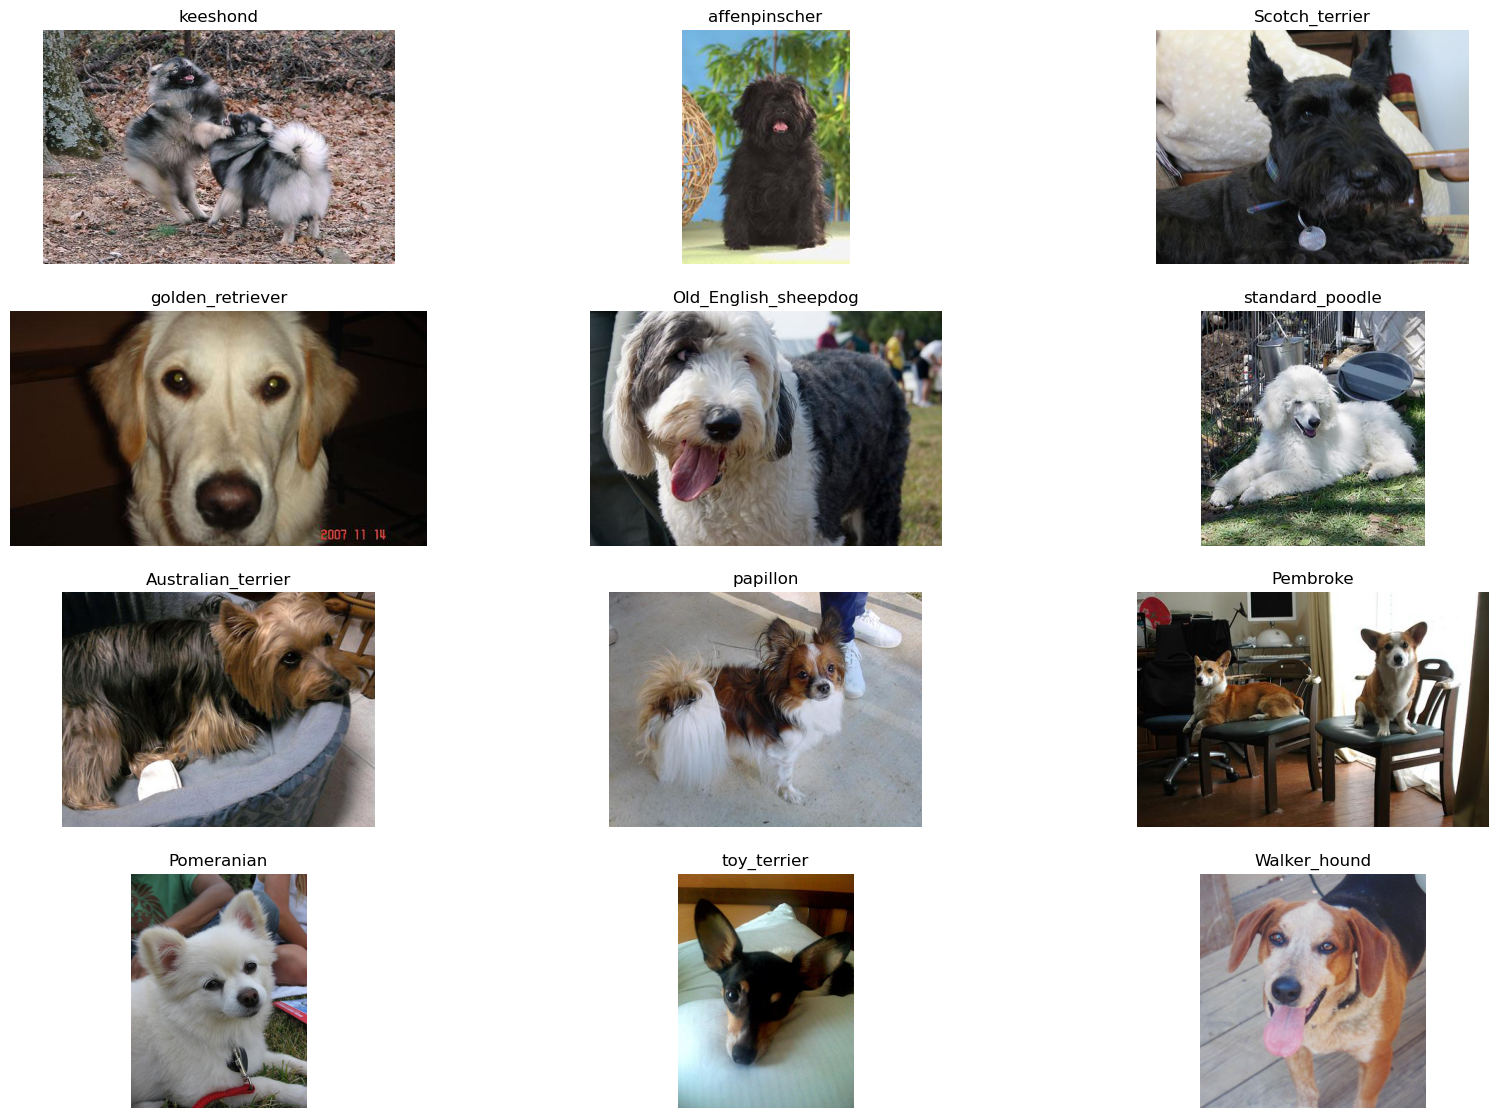

In [8]:
# Display some sample images from the dataset
fig, axis = plt.subplots(4, 3, figsize=(20, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Labels[i])
    ax.axis('off')
plt.show()

In [9]:
# Load the saved model from file
model = load_model('/kaggle/input/inceptionv3-model/InceptionV3_model_2023_03_25-0817.h5')

# build a test dataframe 
_ , test = train_test_split(df, test_size=0.2)

# Create an ImageDataGenerator object to rescale the test data
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 64
target_size=(299, 299)

# Create a test generator using the test data and the test_datagen object
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col="Filepath",
    y_col="Labels",
    batch_size=batch_size,
    shuffle=False,
    target_size=target_size
)

Found 4116 validated image filenames belonging to 120 classes.


In [10]:
# Evaluate the model on the test set
loss, acc = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print(f"loss on the test set is {loss:.2f}")
print(f"accuracy on the test set is {acc:.3f}")

64/64 [==============================] - 50s 662ms/step - loss: 0.3986 - accuracy: 0.9172
loss on the test set is 0.40
accuracy on the test set is 0.917


In [11]:
# Get the class indices
class_indices = test_generator.class_indices

# Print the class indices in a prettier way
print(json.dumps(class_indices, indent=4))

{
    "Afghan_hound": 0,
    "African_hunting_dog": 1,
    "Airedale": 2,
    "American_Staffordshire_terrier": 3,
    "Appenzeller": 4,
    "Australian_terrier": 5,
    "Bedlington_terrier": 6,
    "Bernese_mountain_dog": 7,
    "Blenheim_spaniel": 8,
    "Border_collie": 9,
    "Border_terrier": 10,
    "Boston_bull": 11,
    "Bouvier_des_Flandres": 12,
    "Brabancon_griffon": 13,
    "Brittany_spaniel": 14,
    "Cardigan": 15,
    "Chesapeake_Bay_retriever": 16,
    "Chihuahua": 17,
    "Dandie_Dinmont": 18,
    "Doberman": 19,
    "English_foxhound": 20,
    "English_setter": 21,
    "English_springer": 22,
    "EntleBucher": 23,
    "Eskimo_dog": 24,
    "French_bulldog": 25,
    "German_shepherd": 26,
    "German_short": 27,
    "Gordon_setter": 28,
    "Great_Dane": 29,
    "Great_Pyrenees": 30,
    "Greater_Swiss_Mountain_dog": 31,
    "Ibizan_hound": 32,
    "Irish_setter": 33,
    "Irish_terrier": 34,
    "Irish_water_spaniel": 35,
    "Irish_wolfhound": 36,
    "Italian_gre

In [12]:
# Get the first batch of data from the test generator
x_test, y_test = next(test_generator)

# Use the model to make predictions on the first batch of test data
predictions = model.predict(x_test)


2/2 [==============================] - 2s 27ms/step


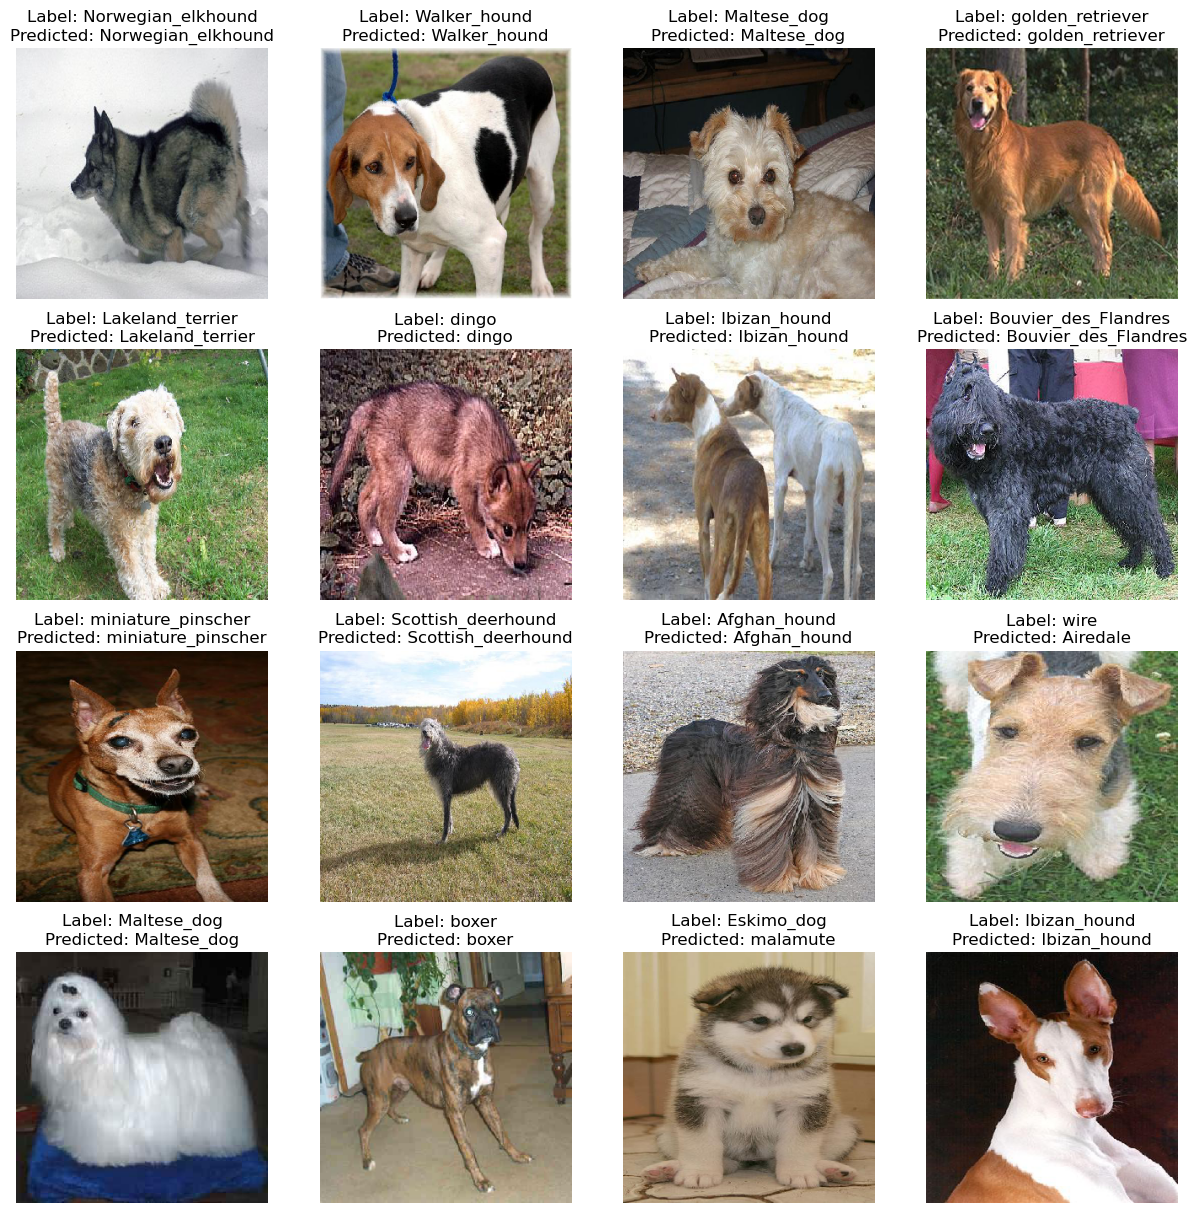

In [13]:
# Visualize the images, labels, and predictions
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[i])
    # Use a dictionary comprehension to get the keys that correspond to the value
    true_labels = [key for key, value in class_indices.items() if value == y_test[i].argmax()]
    prediction_labels = [key for key, value in class_indices.items() if value == predictions[i].argmax()]

    ax.set_title('Label: {}\nPredicted: {}'.format(true_labels[0], prediction_labels[0]))
    ax.axis('off')

In [14]:
# Make predictions using the test generator
full_predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(full_predictions, axis=1)

# Get the ground truth labels (true_classes) from the test generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate the accuracy score
accuracy = accuracy_score(true_classes, predicted_classes)
print("Test Accuracy:", accuracy)


65/65 [==============================] - 29s 423ms/step
Test Accuracy: 0.9173955296404276


In [15]:
# Calculate the classification report (precision, recall, F1-score, support)
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("\nClassification Report:\n", report)


Classification Report:
                                 precision    recall  f1-score   support

                  Afghan_hound       1.00      1.00      1.00        60
           African_hunting_dog       0.98      1.00      0.99        41
                      Airedale       0.95      1.00      0.98        42
American_Staffordshire_terrier       0.79      0.82      0.81        38
                   Appenzeller       0.87      0.65      0.74        31
            Australian_terrier       0.93      0.86      0.89        43
            Bedlington_terrier       0.94      0.97      0.96        33
          Bernese_mountain_dog       0.91      0.98      0.94        43
              Blenheim_spaniel       0.92      0.97      0.94        35
                 Border_collie       0.72      0.96      0.83        27
                Border_terrier       1.00      0.97      0.98        29
                   Boston_bull       0.91      1.00      0.95        39
          Bouvier_des_Flandres       0

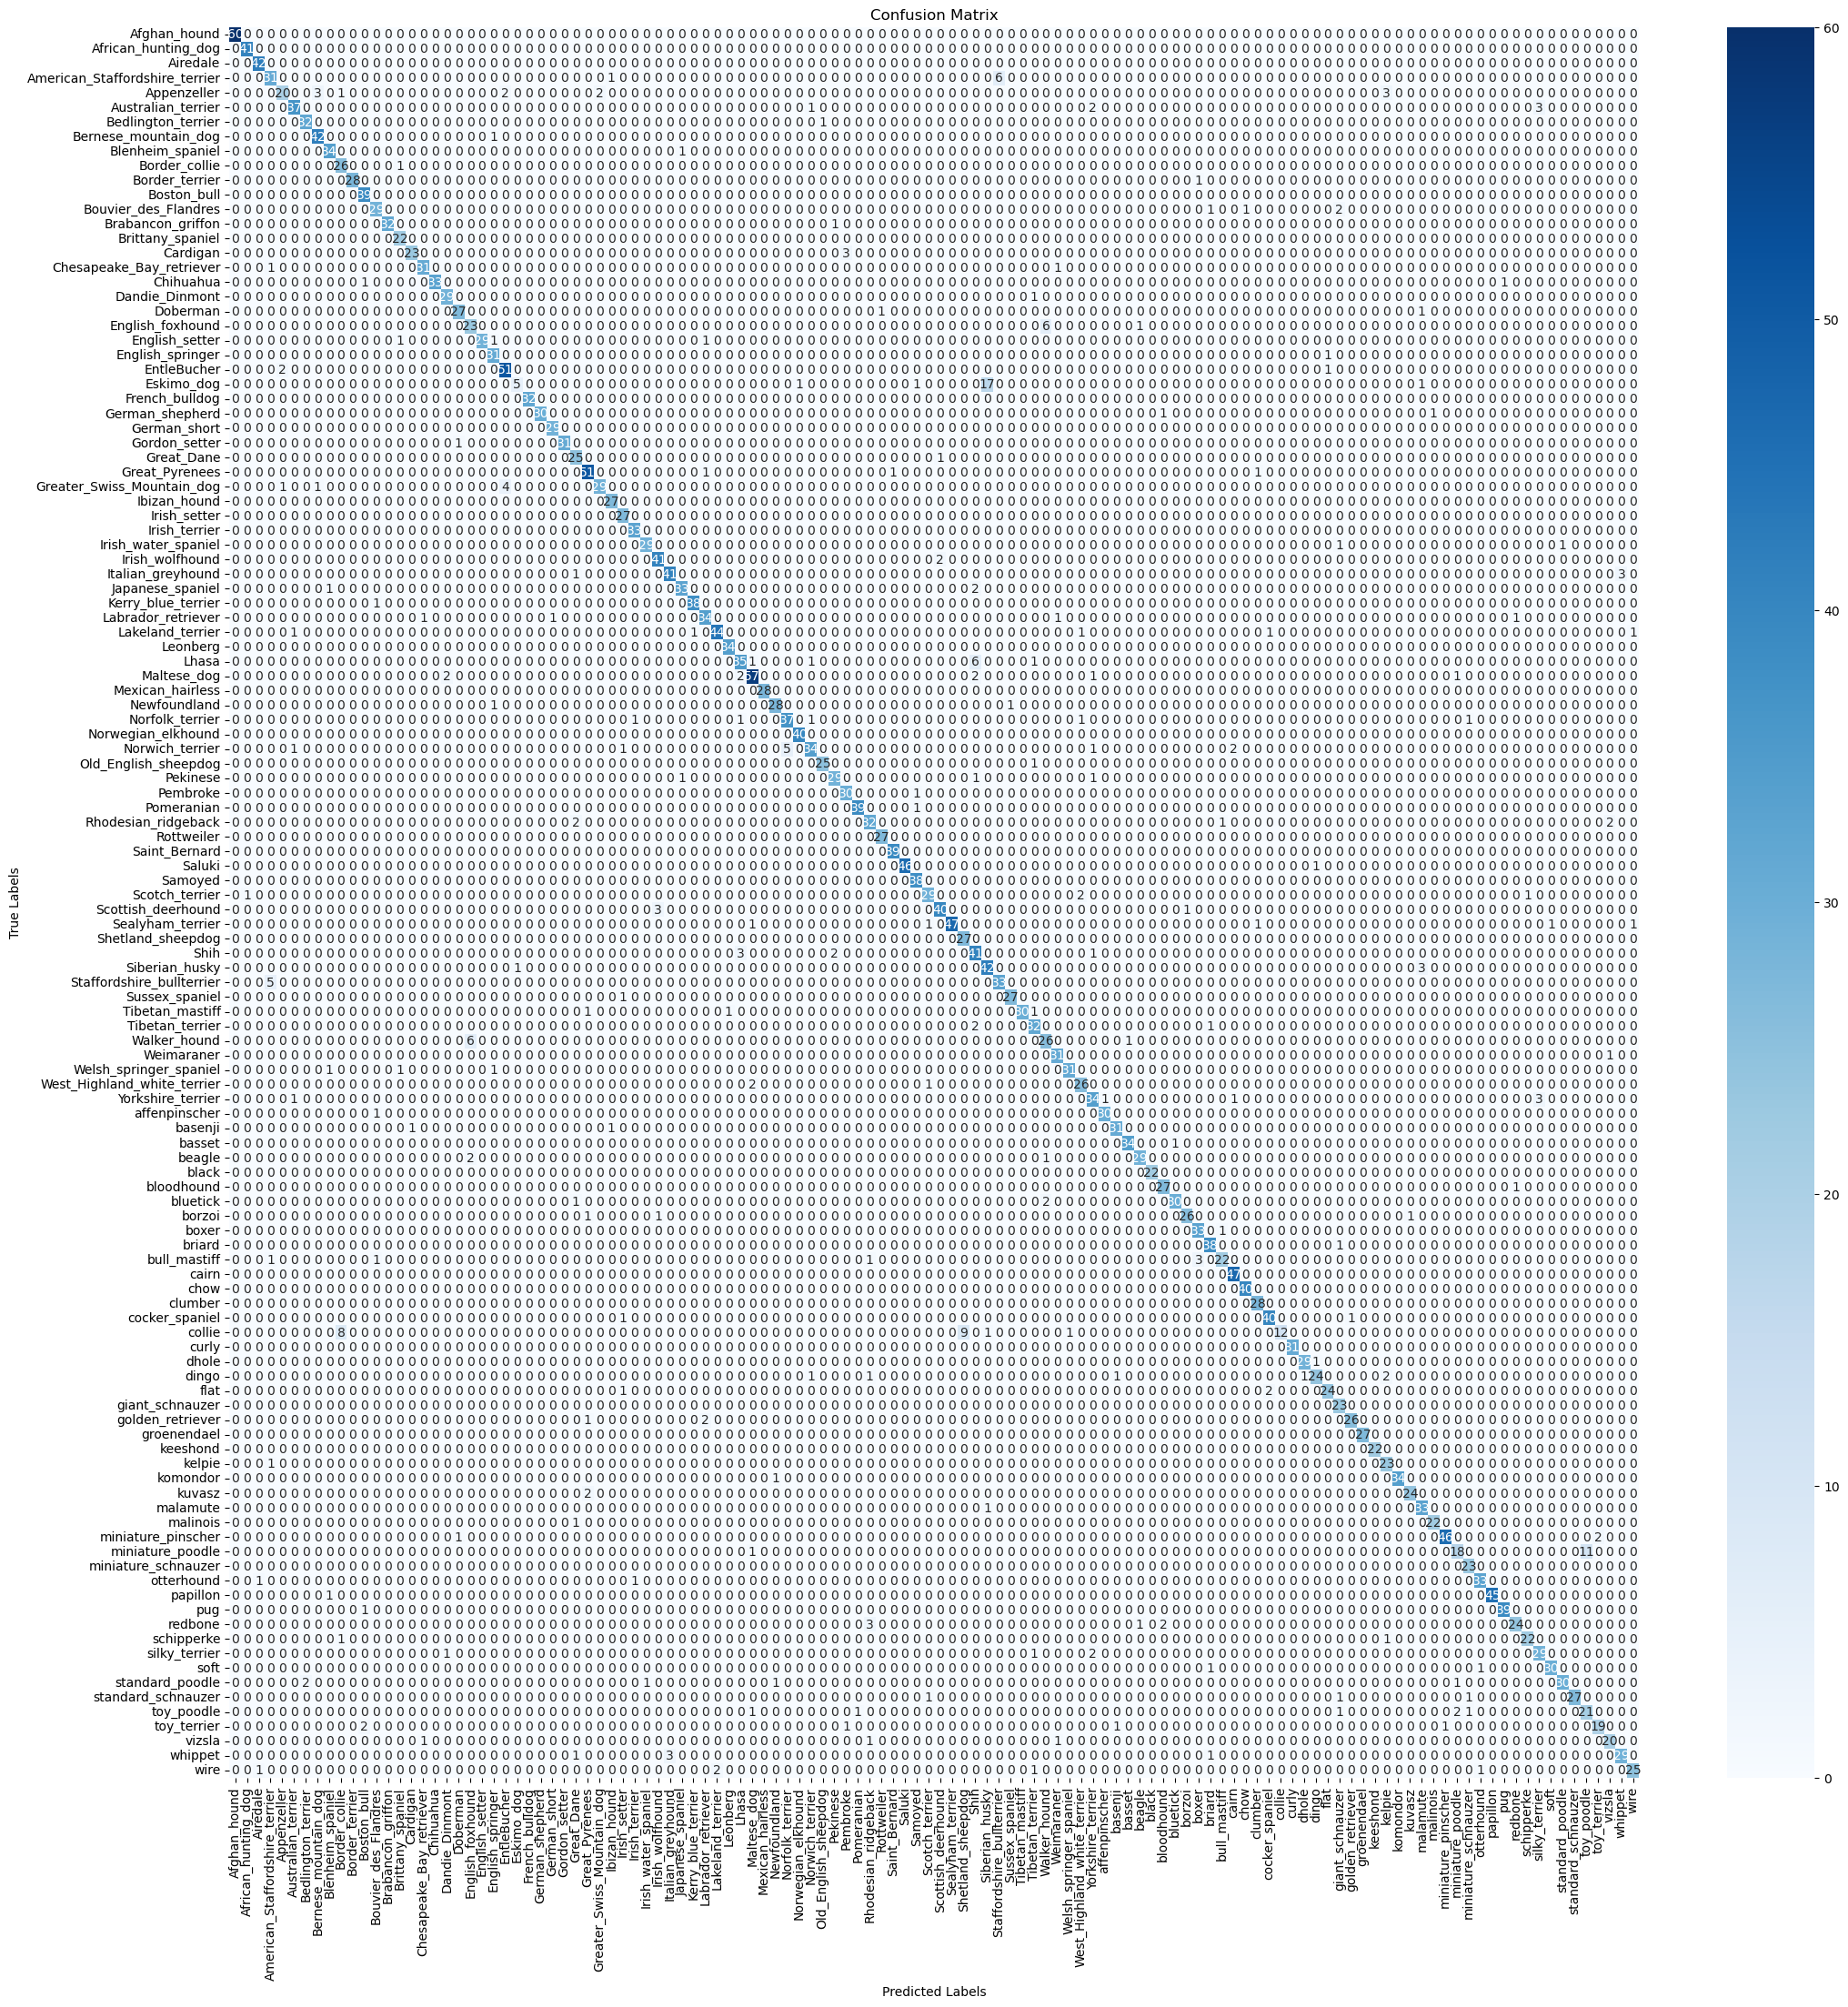

In [16]:

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

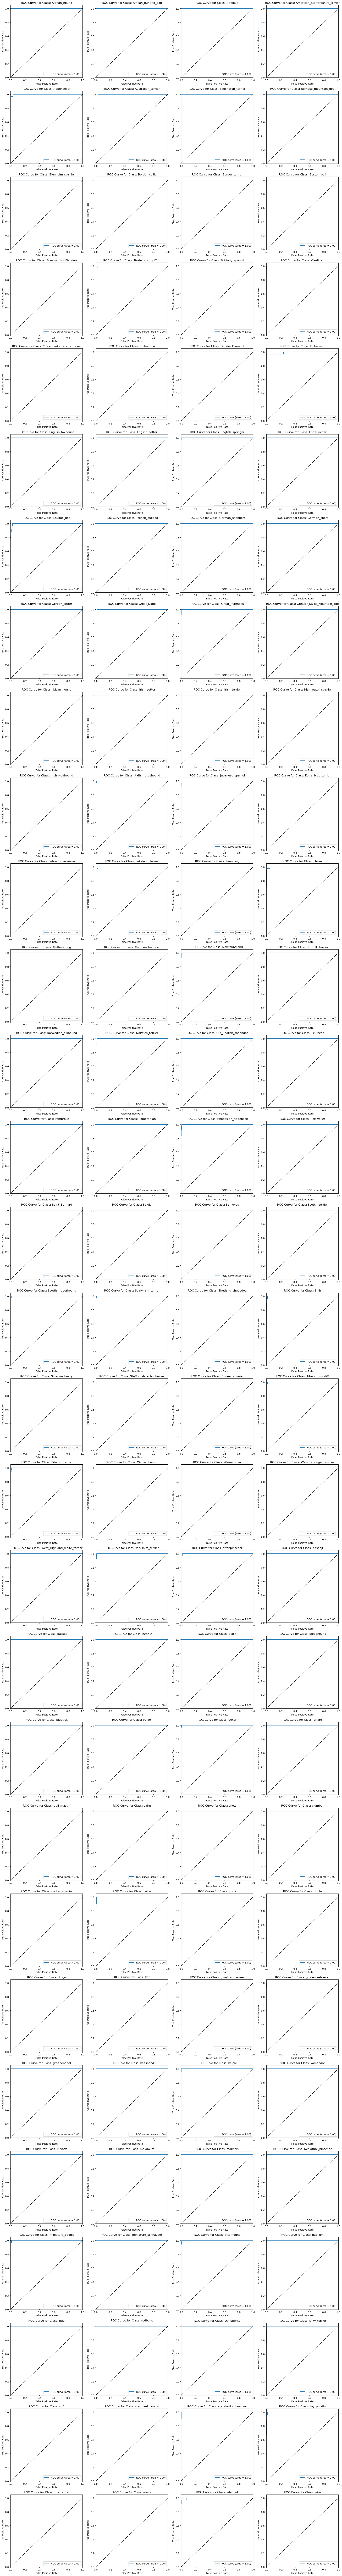

In [17]:

# Get the ground truth labels (true_classes) from the test generator
n_classes = len(test_generator.class_indices)

# Binarize the true_classes to match the shape of the predictions
y_true = label_binarize(true_classes, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], full_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class in separate subplots
fig, axes = plt.subplots(30, 4, figsize=(20, 150))
axes = axes.ravel()

for i in range(n_classes):
    axes[i].plot(fpr[i], tpr[i], label='ROC curve (area = {0:0.2f})'.format(roc_auc[i]))
    axes[i].plot([0, 1], [0, 1], 'k--')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title('ROC Curve for Class: {}'.format(class_labels[i]))
    axes[i].legend(loc="lower right")

# Adjust the layout
fig.tight_layout()
plt.show()